In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.4 MB/s eta 0:00:00


In [3]:
data=pd.read_csv('/content/drive/MyDrive/60/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
data['class'].value_counts()
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [5]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

**DATA VISUALISATIONS**

In [6]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [7]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])

**DATA CLEANING**

In [8]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:02<00:00, 15938.48it/s]


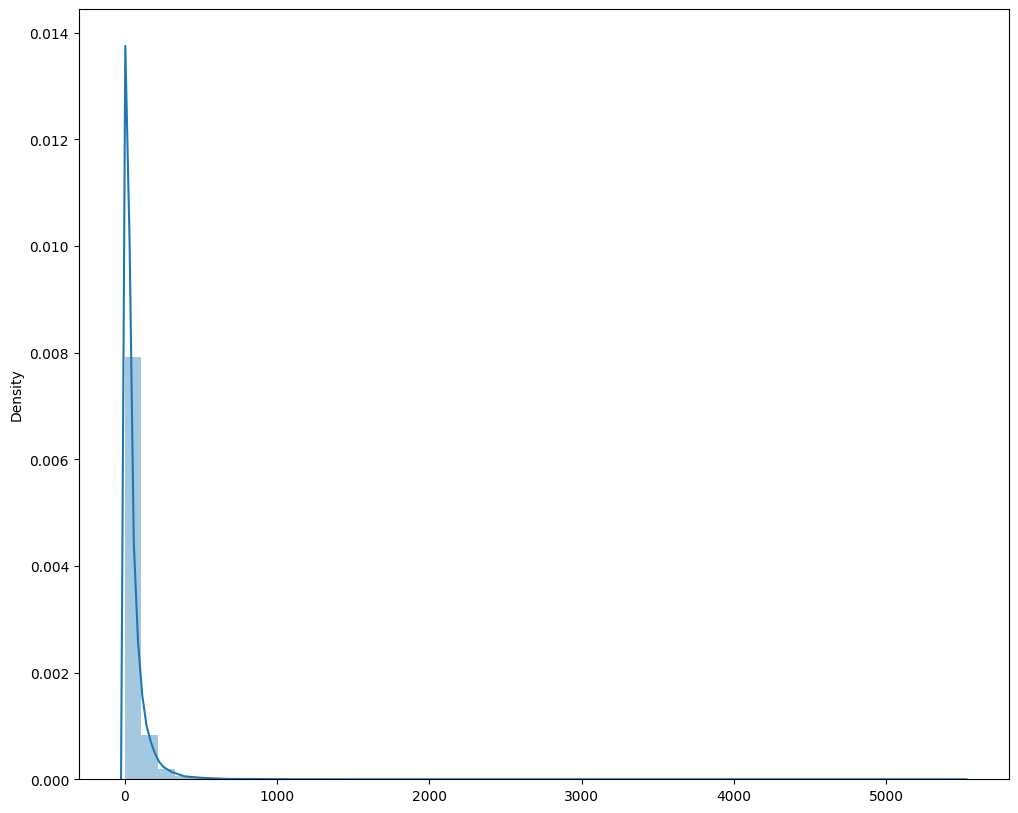

In [9]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
plt.show()

In [10]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [11]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

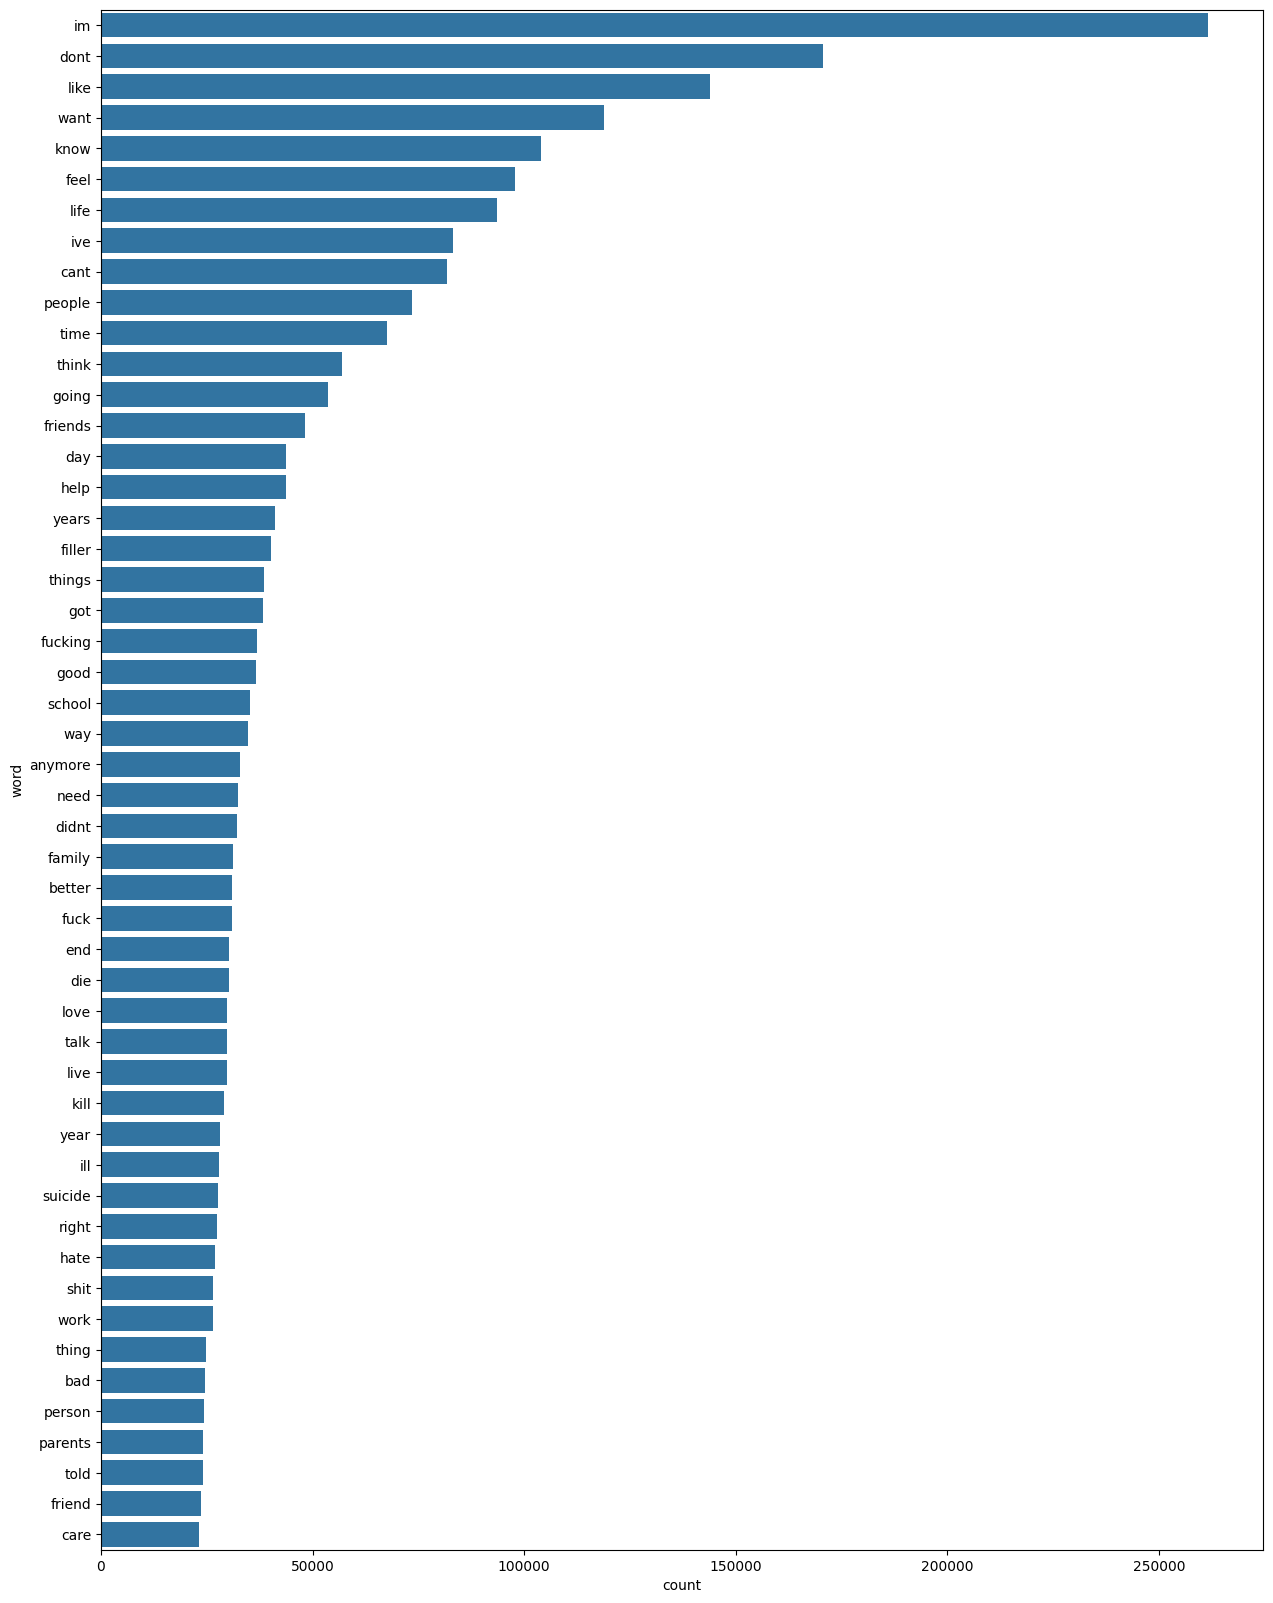

In [12]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

In [18]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=40)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=40)

lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [19]:
with open('/content/drive/MyDrive/60/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [20]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 80s 107ms/step - loss: 0.3590 - accuracy: 0.8458 - val_loss: 0.2613 - val_accuracy: 0.8967 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 69s 95ms/step - loss: 0.2549 - accuracy: 0.8980 - val_loss: 0.2391 - val_accuracy: 0.9061 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 71s 97ms/step - loss: 0.2335 - accuracy: 0.9073 - val_loss: 0.2214 - val_accuracy: 0.9126 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 69s 95ms/step - loss: 0.2175 - accuracy: 0.9146 - val_loss: 0.2838 - val_accuracy: 0.8836 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 69s 95ms/step - loss: 0.2046 - accuracy: 0.9193 - val_loss: 0.2139 - val_accuracy: 0.9165 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 64s 88ms/step - loss: 0.1941 - accuracy: 0.9241 - val_loss: 0.2515 - val_accuracy: 0.9005 - lr: 0.1000
Epoch 7/20
726/726 [==============================] - 72s

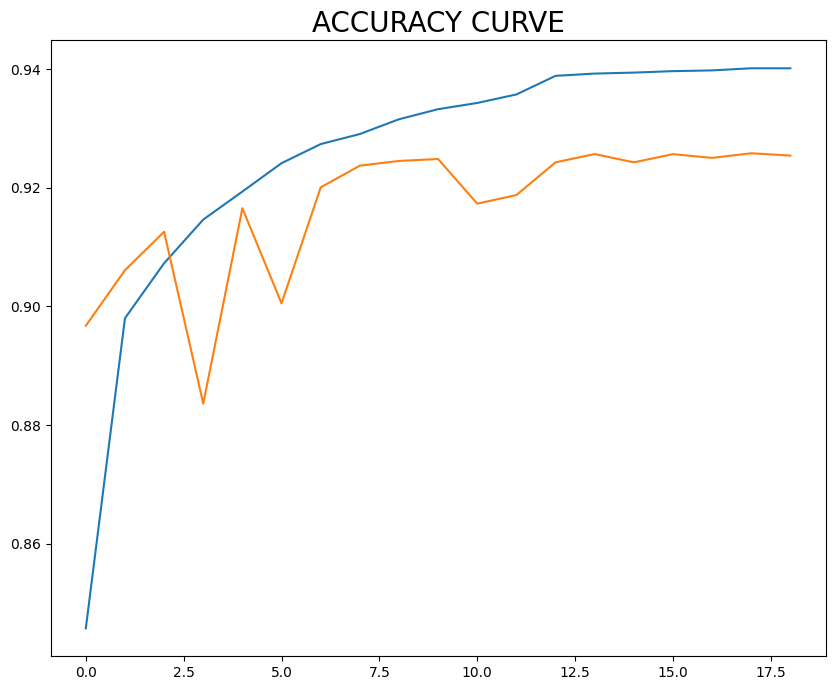

In [22]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

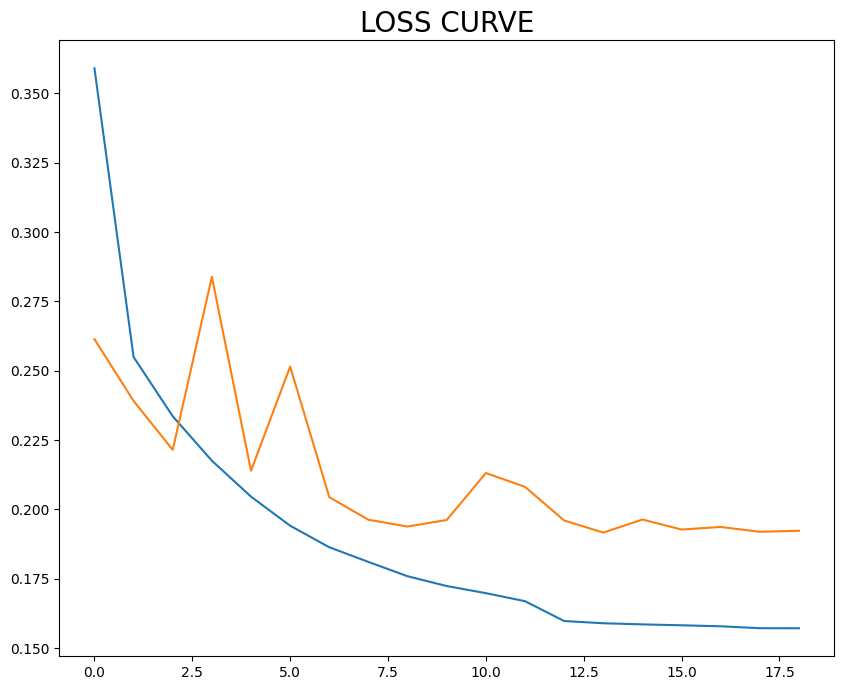

In [24]:
plt.figure(figsize=(10,8))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()